In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [41]:
images = 'data\Images\\'
captions = "data\captions.txt"

In [42]:
data = pd.read_csv(captions)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [43]:
def readImage(images, img_size=224):
    img = load_img(images, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255

    return img

def display_images(df):
    df = df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(images + df.image[i])

        plt.imshow(image)
        plt.title("\n".join(wrap(df.caption[i], 20)))
        plt.axis("off")

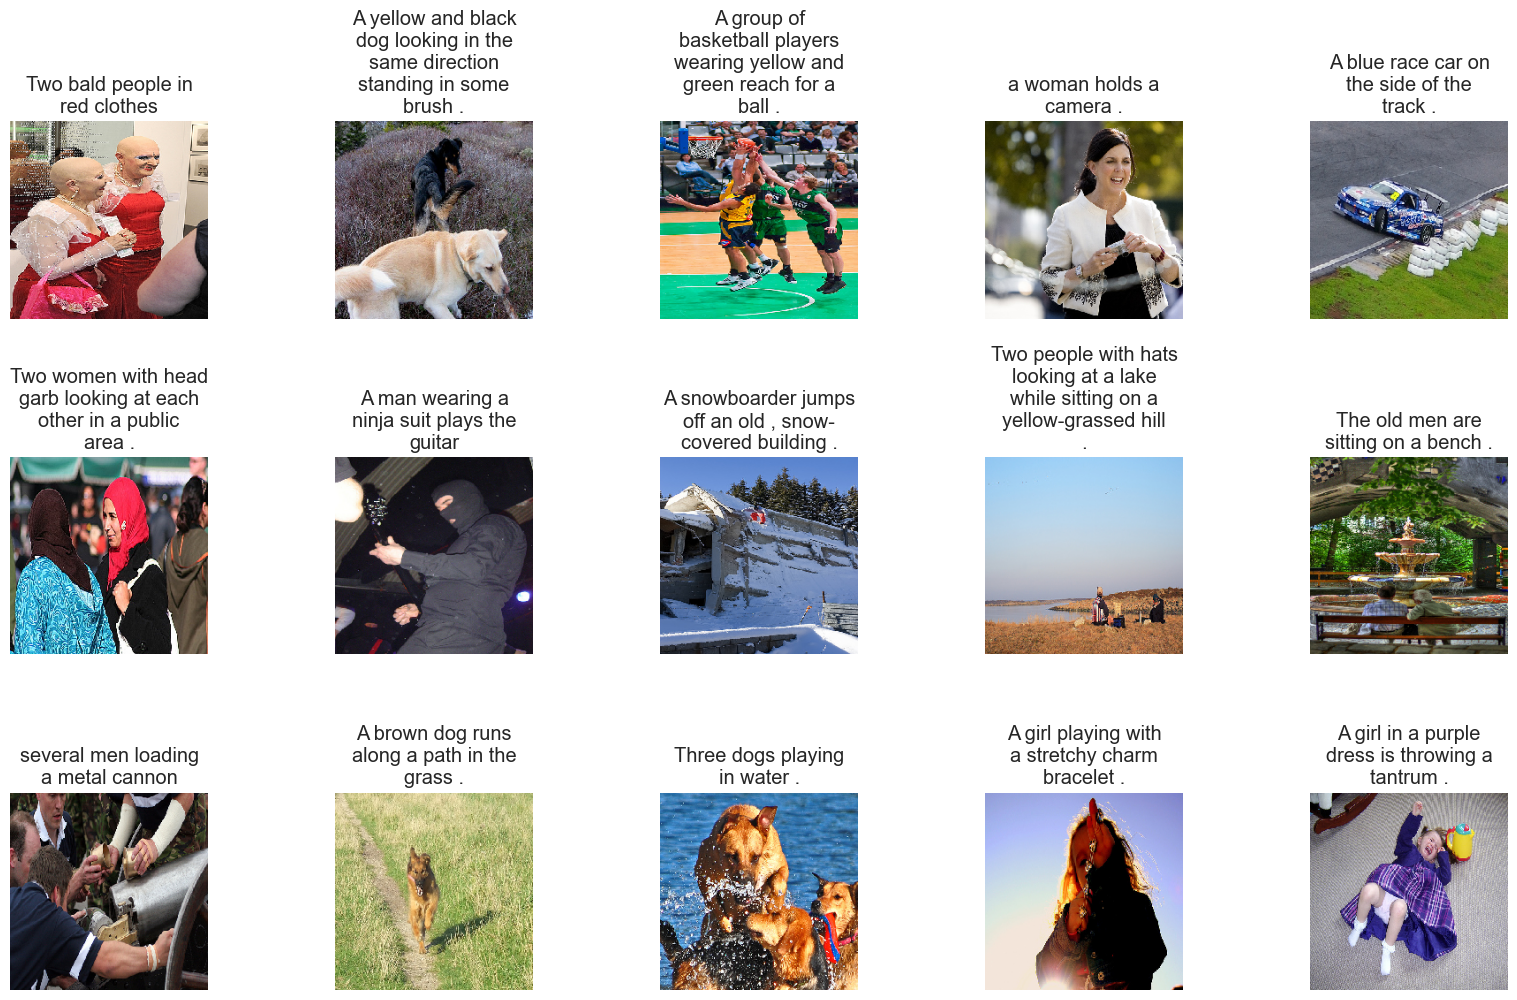

In [45]:
display_images(data.sample(15))

In [46]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [51]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq startseq startseq startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq girl going into wooden building endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq little girl climbing into wooden playhouse endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq little girl climbing the stairs to her playhouse endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq little girl in pink dress going into wooden cabin endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq black dog and spotted dog are fighting endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq endseq endseq endseq',
 'startseq startseq startseq startseq startseq black dog and white d

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)


TypeError: 'Tokenizer' object is not callable